# Location Intelligence Data Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
np.random.seed = 42

# Feature Engineering

In [2]:
df = pd.read_csv('./DATA/google_places_data.csv')

In [3]:
df = df.dropna(how='any').reset_index(drop = True)
df = df.drop_duplicates(subset=['business_id'])

#### Outliers

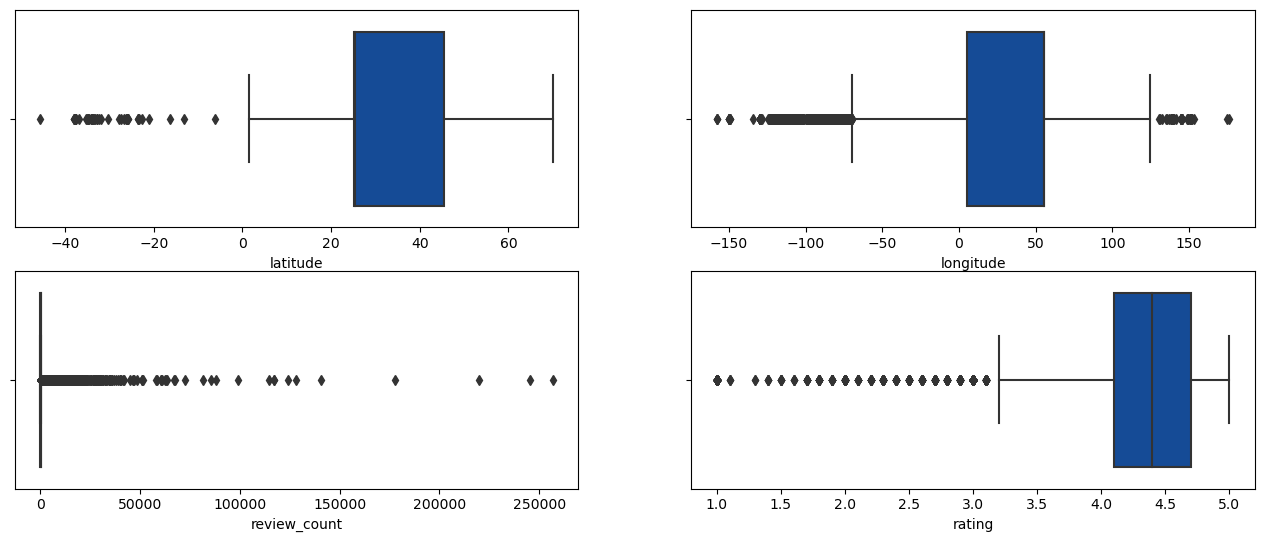

In [4]:
plt.figure(figsize = (16,13))

for i, col in enumerate(['latitude', 'longitude', 'review_count', 'rating']):
    plt.subplot(4,2,i+1)
    sns.boxplot(x = col, data = df, color='#0047AB')
plt.show()

##### Cutting off review_count

In [5]:
review_count_count = df["review_count"].value_counts().reset_index(name='count')
review_count_count = review_count_count[review_count_count['count'] > 100]
review_count_count

,review_count,count
0,32.0,2734
1,1.0,1054
2,2.0,713
3,3.0,543
4,4.0,412
5,5.0,334
6,6.0,255
7,7.0,252
8,8.0,236
9,9.0,218


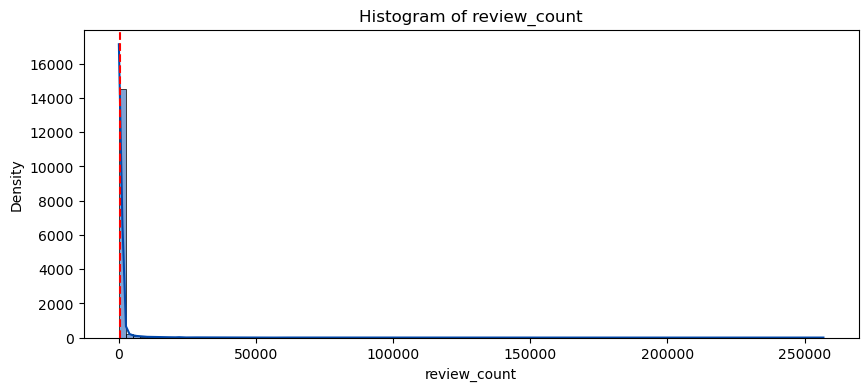

Value above which highest 10% of the data falls: 565.0


In [6]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')

highest_10_percent = df['review_count'].quantile(0.90)
plt.axvline(x=highest_10_percent, color='red', linestyle='--')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()
print("Value above which highest 10% of the data falls:", highest_10_percent)

In [7]:
df.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent

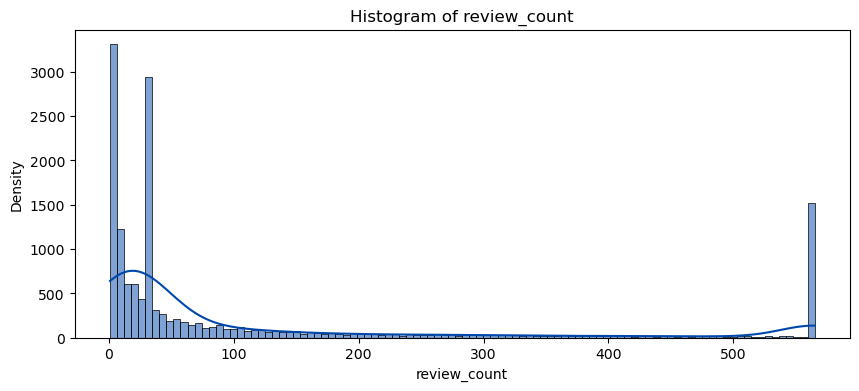

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()

In [9]:
# nie usuwałabym rating te niskie oceny mogą być dość istotne dla modelu

##### Cutting off rating

In [10]:
# plt.figure(figsize=(10, 5))
# sns.histplot(df['rating'], bins=41, kde=True, color='#bb2e00', edgecolor='black')

# lowest_2_percent = df['rating'].quantile(0.02)
# plt.axvline(x=lowest_2_percent, color='red', linestyle='--')
# plt.title('Histogram of rating')
# plt.xlabel('rating')
# plt.ylabel('Density')
# plt.show()
# print("Value above which lowest 2% of the data falls:", lowest_2_percent)

In [11]:
# df.loc[df['rating'] < lowest_2_percent, 'rating'] = lowest_2_percent

In [12]:
# plt.figure(figsize=(10, 5))
# sns.histplot(df['rating'], bins=29, kde=True, color='#bb2e00', edgecolor='black')
# plt.title('Histogram of rating')
# plt.xlabel('rating')
# plt.ylabel('Density')
# plt.show()

#### Column removal

In [13]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
business_id,15103
phone_number,11277
name,14187
full_address,14737
latitude,14418
longitude,14422
review_count,550
rating,40
timezone,112
website,7529


In [14]:
df = df.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])

Some categorical columns have values that are mostly unique to each record in the dataset. As a result, they will not be valuable for our model and we decided to remove them. 

Removed columns: 
* business_id
* phone_number	
* name	
* full_address 
* place_id 
* place_link	

In [15]:
df = df.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening'])

From the EDA stage, we know that the columns related to business operating hours are highly correlated with each other, so we have decided to remove these columns as well.

In [16]:
df = df.drop(columns=['geo_cluster'])

We decided to remove the geo_cluster column, which resulted from a previous clustering performed on the data.

In [17]:
df.shape

(15103, 18)

In [18]:
df.head()

,latitude,longitude,review_count,rating,timezone,website,types,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,city,verified,state,country
0,23.733973,53.980629,58.0,4.7,Asia/Dubai,Unknown,Museum,2-6 PM,10 AM-6 PM,10 AM-6 PM,10 AM-6 PM,10 AM-6 PM,10 AM-6 PM,10 AM-6 PM,Abu Dhabi,False,Open ⋅ Closes 6 PM,United Arab Emirates
1,23.657332,53.741881,3.0,3.0,Asia/Dubai,Unknown,Museum,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Abu Dhabi,False,Open 24 hours,United Arab Emirates
2,23.611601,58.593728,565.0,4.6,Asia/Muscat,https://www.nm.gov.om/,"National museum, Museum, Tourist attraction",2-6 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,Muscat,True,Open ⋅ Closes 5 PM,Oman
3,53.477136,-2.254582,565.0,4.4,Europe/London,https://www.scienceandindustrymuseum.org.uk/,"Science museum, Heritage museum, Museum, Touri...",10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,Manchester,True,Open ⋅ Closes 5 PM,United Kingdom
4,54.884752,-1.659321,565.0,4.8,Europe/London,https://www.beamish.org.uk/,"Open air museum, Museum, Tourist attraction",10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,Stanley,True,Open ⋅ Closes 5 PM,United Kingdom


### Train, Validation and Test Sets

In [19]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42)
X_train, X_val = train_test_split(X_dev, test_size=0.3, random_state=42)